## Homework 5: FX Carry Trade Strategy
### FINM 33150 (Winter 2025) - Quantitative Trading Strategies
#### NAME: Arturo Charleston
#### Student ID: 12449584

## Introduction
In this notebook, I implement an FX carry trade strategy where I borrow in GBP (a relatively low-interest-rate currency) and invest in fixed-income instruments denominated in high-yield currencies: Costa Rican Colón (CRC), Pakistani Rupee (PKR), Turkish Lira (TRY), and South African Rand (ZAR). The goal of the strategy is to capture the interest rate differential between GBP and these higher-yielding currencies while managing the risks associated with currency fluctuations.


The approach follows a systematic process:

- Funding Side: I assume borrowing at the UK overnight index swap (OIS) rate plus a spread of 50 basis points.

- Investment Side: Each week, I invest in bonds priced off the 5-year swap rates of the selected high-yield currencies. These bonds are structured as par swaps, meaning they start at par value, with quarterly coupons set at the prevailing 5-year swap rate.
- Mark-to-Market: Every week, I close the existing position, mark the investment to market using the new swap curve, and convert everything back to USD. The key risks here come from interest rate changes and exchange rate movements.

The strategy operates with leverage (typically 4:1), meaning the notional position size is significantly larger than the equity portion. To avoid entering trades with insufficient carry, I impose a threshold where a trade is only initiated if the spread between the local 5-year swap rate and the OIS (UK Overnight Index Swap) is above a set level.

### Analysis
Once the trade mechanics are implemented, I analyze the performance of the strategy in several ways:

- Return and Risk Metrics: I calculate weekly returns, cumulative returns, Value-at-Risk (VaR), and expected shortfall (CVaR).
- Correlation Analysis: I check the relationships between different currency strategies and major market factors (e.g., Fama-French factors, ETFs, and macroeconomic indicators).
- Regressions: I estimate betas for the carry returns against broader market and ETF factors to understand systematic risk exposure.
- Carry Trade as an Option-Like Payoff: Since carry trades often unwind during market stress (when high-yielding currencies depreciate sharply), I explore whether the return distribution behaves like a short volatility position or resembles a put option structure.

Through these steps, I evaluate whether the FX carry trade generates consistent returns, how it performs under different market conditions, and how much risk it introduces.

In [21]:
# PACKAGES
import os
import warnings
import nasdaqdatalink
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from pyprojroot import here
from fredapi import Fred

# Global Options
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

# Set directory
home_directory = "/Users/charleston/Downloads/git_repositories/finm-qts-2025"
os.chdir(home_directory)

# KEYS
from config import FRED_KEY
from config import QUANDL_KEY

nasdaqdatalink.ApiConfig.api_key = QUANDL_KEY

#from my_functions import *

# Dates
start_date = '2010-01-01'
end_date = "2025-01-01"


## FUNCTIONS

In [31]:
# FUNCTIONS
def fetch_fred(fred_key, series_ids, output_dir='./data'):
    """
    Fetches data from FRED API and saves it to CSV files.

    Parameters:
    fred_key (str): API key for FRED.
    series_ids (dict): Dictionary with category as key and series ID as value.
    output_dir (str): Directory to save the CSV files. Default is './data'.

    Returns:
    None
    """
    fred = Fred(api_key=fred_key)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for category, series_id in series_ids.items():
        data = fred.get_series(series_id)
        data = data.reset_index()
        data.columns = ['date', 'value']
        data.to_csv(f'{output_dir}/{series_id}.csv', index=False)

        data_old = fred.get_series_first_release(series_id)
        data_old = data_old.reset_index()
        data_old.columns = ['date', 'value']
        data_old.to_csv(f'{output_dir}/{series_id}_first_release.csv', index=False)

def fix_swap_curve_missing_values(df):
    """
    Adapts logic from the original fix function to your single-level columns:
      index = date,
      columns = [tenor, ZAR, TRY, CRC, PKR].
    We'll fill missing yields by date:
      - If a date has <=2 non-NaNs for a currency, we fill from previous date.
      - Else we try an interpolate within that date's row if partial data is present.
    """
    df_clean = df.copy().sort_index()

    # We'll track the previous row for each date if we need to fill
    prev_date = None
    prev_data = None  # store the row(s) from the previous date

    # We'll accumulate rows here
    fixed_rows = []

    unique_dates = df_clean.index.unique()

    for i, current_date in enumerate(unique_dates):
        # Gather all rows for current_date
        date_slice = df_clean.loc[[current_date]]
        
        # 'date_slice' has multiple rows (one per tenor)
        # We'll group by tenor or just iterate over them
        # but we want to fix missing yields for each currency.

        if i == 0:
            # No previous date
            fixed_rows.append(date_slice)
            prev_date = current_date
            prev_data = date_slice
            continue

        # We'll fill for each row's [ZAR, TRY, CRC, PKR] if missing
        # The approach:
        #   - If # of non-NaNs for a given row < 2 => fill from prev date
        #   - else we do a simple row-based interpolation if partial data
        row_list = []
        for idx, row in date_slice.iterrows():
            # idx is (current_date), row has: tenor, ZAR, TRY, CRC, PKR
            # We do not expect columns beyond these
            # Count non-NaN among ZAR, TRY, CRC, PKR
            valid_count = row[['ZAR','TRY','CRC','PKR']].notna().sum()
            if valid_count <= 2 and prev_data is not None:
                # fill from prev date's row with matching tenor if possible
                tenor_val = row['tenor']
                # find the row from prev_data with the same tenor
                prev_row_match = prev_data[ prev_data['tenor'] == tenor_val ]
                if not prev_row_match.empty:
                    # fill
                    row[['ZAR','TRY','CRC','PKR']] = prev_row_match[['ZAR','TRY','CRC','PKR']].iloc[0].values
            else:
                # Attempt interpolation among the 4 currencies if partial data
                row[['ZAR','TRY','CRC','PKR']] = row[['ZAR','TRY','CRC','PKR']].interpolate(limit_direction='both', axis=0)
            
            row_list.append(row)

        fixed_df_slice = pd.DataFrame(row_list, columns=date_slice.columns).set_index(date_slice.index)
        fixed_rows.append(fixed_df_slice)

        prev_date = current_date
        prev_data = fixed_df_slice  # store for next iteration

    # Combine
    out_df = pd.concat(fixed_rows).sort_index()
    return out_df

def bootstrap_discount_factors(swap_rates, freq=4, max_horizon=10.0):
    step = 1.0 / freq
    grid = np.arange(step, max_horizon + step, step)
    
    known_maturities = np.array(list(swap_rates.keys()))
    known_rates      = np.array(list(swap_rates.values()))
    sort_idx = np.argsort(known_maturities)
    known_maturities = known_maturities[sort_idx]
    known_rates      = known_rates[sort_idx]
    
    interp_rates = np.interp(grid, known_maturities, known_rates)

    disc = pd.Series(index=grid, dtype=float)
    for i, tau in enumerate(disc.index):
        r_tau = interp_rates[i]
        scale = 1.0 / freq
        if i == 0:
            numerator = 1
        else:
            numerator = 1 - (r_tau / freq) * disc.iloc[:i].sum()
        denominator = 1 + r_tau * scale
        disc.iloc[i] = numerator / denominator
    return disc


def price_fixed_leg(original_coupon, disc_factors, freq=4, remaining_years=5.0):
    step = 1.0 / freq
    times = np.arange(step, remaining_years + step, step)

    disc_times = disc_factors.index.values
    disc_vals  = disc_factors.values
    df_at_times = np.interp(times, disc_times, disc_vals)

    coupon_leg = ((original_coupon / freq) * df_at_times).sum()
    return coupon_leg + df_at_times[-1]

# Convert swap rates to zero-coupon rates
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.items():  # use .items() instead of .iteritems()
            if tenor > 0.001:
                times = np.arange(tenor - 0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5 * spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values)
                preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
                zcb_rates[curve].loc[tenor] = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor
    return zcb_rates

def carry_trade_bootstrap(
    ois_weekly: pd.DataFrame,
    fx_weekly: pd.DataFrame,
    swap_weekly: pd.DataFrame,
    currency: str = 'TRY',
    notional_usd: float = 10_000_000.0,
    leverage: float = 4.0,
    freq: int = 4,
    threshold: float = 0.0
) -> pd.DataFrame:
    """
    Carry trade using bootstrap_discount_factors + price_fixed_leg (like 'other code').
    
    - We assume swap_weekly is indexed by (date, tenor), with columns = [ZAR, TRY, PKR, CRC].
    - Each week, we:
      1) Borrow in GBP at (UK_OIS + 50bps) [annual].
      2) Build a dictionary {0.5: yield, 1.0: yield, 5.0: yield, 10.0: yield} for the currency.
      3) Bootstraps discount factors => price a par swap at date_in. 
      4) At date_out (1 week later), re-bootstrap with 4 points => new price with (5.0 - 1/52) yrs.
      5) Convert P/L to USD, subtract funding cost, store results.
    
    threshold: open trade only if (local_5y - SONIA) >= threshold
    """
    results = []

    # We'll gather all weekly dates from SONIA
    weekly_dates = sorted(ois_weekly.index)
    borrowed_usd = notional_usd * (leverage / (1 + leverage))

    needed_tenors = [0.5, 1.0, 5.0, 10.0]

    for i in range(len(weekly_dates) - 1):
        date_in = weekly_dates[i]
        date_out = weekly_dates[i + 1]

        # 1) Funding side (annual rate assumption)
        try:
            ois_annual = ois_weekly.loc[date_in, 'UK_OIS']
        except KeyError:
            continue
        annual_funding_rate = ois_annual + 0.005  # +50 bps annual
        # weekly interest portion
        weekly_interest_rate = annual_funding_rate / 52.0
        funding_cost_usd = borrowed_usd * weekly_interest_rate

        # 2) Build dictionary of yields for date_in
        ccy_swap_rates_in = {}
        # We'll attempt to fetch each needed tenor from swap_weekly
        missing_data = False
        for t in needed_tenors:
            try:
                ccy_yield = swap_weekly.loc[(date_in, t), currency]
            except KeyError:
                missing_data = True
                break
            if pd.isna(ccy_yield):
                missing_data = True
                break
            ccy_swap_rates_in[t] = ccy_yield
        if missing_data or len(ccy_swap_rates_in) < len(needed_tenors):
            # skip if we don't have 4 yields
            continue

        # local 5y
        local_5y = ccy_swap_rates_in[5.0]
        # optional threshold check:
        if (local_5y - ois_annual) < threshold:
            # skip if the spread is too small
            continue

        # 3) Bootstrap discount curve at date_in
        disc_in = bootstrap_discount_factors(ccy_swap_rates_in, freq=freq, max_horizon=10.0)
        # Price the par leg (original_coupon=local_5y) for 5.0 yrs
        entry_price = price_fixed_leg(original_coupon=local_5y, disc_factors=disc_in, freq=freq, remaining_years=5.0)

        # 4) Do the same for date_out => time_remaining=5.0 - 1/52
        ccy_swap_rates_out = {}
        missing_data_out = False
        for t in needed_tenors:
            try:
                ccy_yield_out = swap_weekly.loc[(date_out, t), currency]
            except KeyError:
                missing_data_out = True
                break
            if pd.isna(ccy_yield_out):
                missing_data_out = True
                break
            ccy_swap_rates_out[t] = ccy_yield_out
        if missing_data_out or len(ccy_swap_rates_out) < len(needed_tenors):
            continue

        disc_out = bootstrap_discount_factors(ccy_swap_rates_out, freq=freq, max_horizon=10.0)
        new_price = price_fixed_leg(original_coupon=local_5y, disc_factors=disc_out, freq=freq, remaining_years=5.0 - (1.0/52.0))

        # 5) P/L in local currency => (new_price - entry_price) * leveraged notional
        bond_pnl_local = (new_price - entry_price) * (notional_usd * leverage)

        # Convert to USD using day_in => day_out approach
        try:
            fx_in = fx_weekly.loc[date_in, currency]
            fx_out = fx_weekly.loc[date_out, currency]
        except KeyError:
            continue

        # e.g. bond_pnl_ccy = bond_pnl_local * fx_in
        # bond_pnl_usd = bond_pnl_ccy * (1 / fx_out)
        bond_pnl_ccy = bond_pnl_local * fx_in
        bond_pnl_usd = bond_pnl_ccy * (1.0 / fx_out)

        net_pl = bond_pnl_usd - funding_cost_usd

        results.append({
            'date_in': date_in,
            'date_out': date_out,
            'SONIA_annual': ois_annual,
            'local_5y': local_5y,
            'spread': local_5y - ois_annual,
            'entry_price': entry_price,
            'new_price': new_price,
            'bond_pnl_usd': bond_pnl_usd,
            'funding_cost_usd': funding_cost_usd,
            'net_pl': net_pl,
            'fx_in': fx_in,
            'fx_out': fx_out
        })

    return pd.DataFrame(results)


def calculate_return_metrics(df, adj=12, adjusted = True, quantile = 0.05):
    """
    Calculate return metrics for a given dataset (DataFrame or Series).

    Args:
        data: pandas DataFrame or pandas Series
        adj: int, default 12

    Returns:
        results_df: pandas DataFrame
    """

    results_df = pd.DataFrame(index=df.columns)
    if adjusted == True:
        results_df['Annualized Return'] = df.mean() * adj
        results_df['Annualized Volatility'] = df.std() * np.sqrt(adj)
    else:
        results_df['Annualized Return'] = df.mean()
        results_df['Annualized Volatility'] = df.std()

    # This works if you are calculating excess returns
    results_df['Sharpe Ratio'] = results_df['Annualized Return'] / results_df['Annualized Volatility']

    # Include skewness
    results_df['Skewness'] = df.skew()
    # Include Value at Risk
    results_df[f"VaR ({quantile})"] = df.quantile(quantile, axis=0)

    wealth_index = 1000 * (1 + df).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    results_df["Max Drawdown"] = drawdowns.min()

    # Include Kurtosis
    results_df["Excess Kurtosis"] = df.kurtosis()
    
    # Handling Sortino Ratio: avoid dividing by zero
    downside_std = df[df < 0].std()
    results_df['Annualized Sortino Ratio'] = results_df['Annualized Return'] / (downside_std * np.sqrt(adj)) if not downside_std.empty else np.nan

    return results_df



def calc_risk_metrics(data, var=0.05):
    """
    Calculate risk metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of risk metrics.
    """
    summary = dict()
    summary["Skewness"] = data.skew()
    summary["Excess Kurtosis"] = data.kurtosis()
    summary[f"VaR ({var})"] = data.quantile(var, axis=0)
    summary[f"CVaR ({var})"] = data[data <= data.quantile(var, axis=0)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()
    summary['VaR per Vol'] = summary[f"VaR ({var})"]/data.std()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()
    summary['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary["MDD Bottom"] = drawdowns.idxmin()

    recovery_date = []
    peak_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        peak_date.append(previous_peaks[col][:drawdowns[col].idxmin()].idxmax())
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )
    summary["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]
    summary['MDD Peak'] = peak_date

    summary["Duration (days)"] = [
        (i - j).days if isinstance(i, pd.Timestamp) and isinstance(j, pd.Timestamp) else "-"
        for i, j in zip(summary["Recovery"], summary["MDD Bottom"])
    ]

    return pd.DataFrame(summary, index=data.columns)

# You can use this for Linear Factor Pricing Models as you already included for every variable.
def calc_performance_stats_regressions(df, market, risk_free_rate=0, adj=12, intercept=True, save_residuals=False, save_predicted=False):
    # Prepare the DataFrame for results
    performance = pd.DataFrame(columns=['Alpha'] + [f'Beta_{col}' for col in market.columns] + ['Treynor Ratio', 'Information Ratio', 'Tracking Error'])
    residuals = pd.DataFrame(index=df.index) if save_residuals else None
    predicted = pd.DataFrame(index=df.index) if save_predicted else None

    # Define a function to apply regression analysis
    def calculate_stats(series):
        if intercept:
            X = sm.add_constant(market)  # Add constant for intercept
        else:
            X = market
            
        model = sm.OLS(series, X, missing='drop').fit()  # Fit the model

        alpha = (model.params.iloc[0] if intercept else 0) * adj
        betas = model.params.iloc[1:] if intercept else model.params

        # Calculate performance metrics
        treynor_ratio = adj * (series.mean() - risk_free_rate) / betas.iloc[0] if betas.iloc[0] != 0 else np.nan
        tracking_error = (model.resid.std()) * np.sqrt(adj)
        information_ratio = (alpha / tracking_error) if tracking_error != 0 else np.nan
        sortino_ratio = np.sqrt(adj) * series.mean() / series[series < 0].std()
        r_squared = model.rsquared 

        if save_residuals:
            residuals[series.name] = model.resid

        if save_predicted:
            predicted[series.name] = model.predict(X)

        return pd.Series({
            'Alpha': alpha,
            **{f'Beta_{col}': beta for col, beta in zip(market.columns, betas)},
            'Sortino Ratio': sortino_ratio,
            'Treynor Ratio': treynor_ratio,
            'Information Ratio': information_ratio,
            'Tracking Error': tracking_error,
            'R-Squared': r_squared
        })

    # Apply the regression calculation to all numerical columns in the DataFrame
    performance = df.select_dtypes(include=np.number).apply(calculate_stats, axis=0).T

    # Return only the specified output
    if save_residuals:
        return residuals
    if save_predicted:
        return predicted
    return performance


def find_tangency_weights(df, regularization_cov=1, reg_diag = 1, adj_factor=12, expected_returns = None, add_stats = True, portfolio_performance = True):

    if regularization_cov == 1:
        cov_inv = np.linalg.inv(df.cov() * adj_factor)
    else:
        cov = df.cov()
        covdiag = np.diag(np.diag(cov))
        covsum = regularization_cov * (cov + covdiag * reg_diag)
        cov_inv = np.linalg.inv(covsum * adj_factor)

    if expected_returns is not None:
        mu = expected_returns * adj_factor # Remember to use not annualized returns
    else:
        mu = df.mean() * adj_factor
    
    ones = np.ones(df.columns.shape)
    scale = ones @ cov_inv @ mu
    sigmu = cov_inv @ mu
    weights = pd.DataFrame((1/scale) * sigmu, index=df.columns, columns=['Weights'])

    if add_stats:
        mean_returns = df.mean() * adj_factor
        volatility_returns = df.std() * np.sqrt(adj_factor)

        sharpes = mean_returns / volatility_returns

        # Combine the results into a single DataFrame
        annual_stats = pd.DataFrame({
            'Mean Annual Return': mean_returns,
            'Annual Volatility': volatility_returns,
            'Sharpe Ratio': sharpes
        })

        # Combine weights and annual_stats into a single DataFrame
        results = weights.join(annual_stats)
    else:
        results = weights

    if portfolio_performance:
        port_performance = calculate_return_metrics(df @ weights, adj=adj_factor, adjusted=True)
        port_performance.index = ['Tangency Portfolio']

    if portfolio_performance:
        return results, port_performance
    else:
        return results



## Data Preparing

- Download the OIS data from FRED API (IUDSOIA). The rate presented is in annualized terms, we divide it by 100 to convert it into percent. 
- Download the USD/FX rate from QUANDL. I forward fill for the dates without available data
- Use the Swap spot rates from the class files. Then, I interpolate to fill the missing values
- Based on the Swap Spot rates interpolated, I convert it to zero coupon rates
- Then, I convert them into weekly values. I choose Wednesday of each week to reindex because using Wednesday we avoid a non-trading date. 


In [3]:
# Fetch OIS data from FRED
# OIS = Overnight Index Swap
series_ids = {
    'SONIA': 'IUDSOIA',  #  Daily Sterling overnight index average (SONIA) rate
}

fetch_fred(FRED_KEY, series_ids, output_dir='./data/FRED')
SONIA = pd.read_csv('./data/FRED/IUDSOIA.csv').set_index('date')
SONIA.index = pd.to_datetime(SONIA.index)
SONIA = SONIA/100
SONIA.columns = ['UK_OIS']

# Filter to have data from start_date to end_date only
SONIA = SONIA.loc[start_date:end_date]


In [4]:
currencies = ["GBP", "TRY", "PKR", "CRC", "ZAR"]

currencies_data = pd.concat(
    [nasdaqdatalink.get_table('EDI/CUR', code=currency).set_index('date') for currency in currencies]
).sort_index().pivot(columns='code', values='rate').ffill()

currencies_data = currencies_data.loc[currencies_data.dropna(how='any', axis=0).index]
currencies_data = currencies_data.loc[start_date:end_date]

In [5]:
swap_currencies = ['Rep South Africa', 'Rep Turkey', 'Rep Costa Rica', 'Islamic Rep Pakistan']

def tenor_to_numeric(tenor):
    return 0.5 if tenor == '6M' else float(tenor.rstrip('Y'))

swap_curves = (
    pd.read_csv('./data/InferredYieldCurves_2025-02-04.tab', sep='\t')
    .query('shortname in @swap_currencies')
    .sort_values(by=['date','shortname','tenor'])
    .pivot_table(
        index=['date','tenor'],
        columns='shortname',
        values='yield'
    )
    .rename(columns={
        'Rep South Africa': 'ZAR',
        'Rep Turkey': 'TRY',
        'Rep Costa Rica': 'CRC',
        'Islamic Rep Pakistan': 'PKR'
    })
    .reset_index()     # so we now have columns [date, tenor, ZAR, TRY, CRC, PKR]
    .set_index('date') # index = date, columns = [tenor, ZAR, TRY, CRC, PKR]
)

# Convert "tenor" strings into numeric
swap_curves['tenor'] = swap_curves['tenor'].apply(tenor_to_numeric)

# The result: index=date, columns=[tenor, ZAR, TRY, CRC, PKR].
swap_curves.sort_index(inplace=True)

swap_curves = swap_curves.loc[start_date:end_date]

swap_curves_interpolated = fix_swap_curve_missing_values(swap_curves)
swap_curves_interpolated.index = pd.to_datetime(swap_curves_interpolated.index)

In [6]:
# 3. Process all dates from swap_curves into a new DataFrame "zcb_all"
zcb_all = pd.concat([
    # For each date, convert tenor strings, pivot to have tenor as index and currencies as columns,
    # apply the compute_zcb_curve function, then add a 'date' column.
    compute_zcb_curve(
        grp.assign(tenor=grp['tenor'])
           .set_index('tenor')[['PKR', 'CRC', 'ZAR', 'TRY']]
           .sort_index()
    ).assign(date=d).reset_index()
    for d, grp in swap_curves_interpolated.groupby(swap_curves.index)
]).set_index(['date']).sort_index()

zcb_all.index = pd.to_datetime(zcb_all.index)

In [7]:
# Resample to weekly data

# 1. Resample SONIA (UK OIS) to weekly (Wednesday)
ois_weekly = (
    SONIA
    .resample('W-WED')   # Use Wednesday
    .last()
)
# 2. Resample FX data to weekly (Wednesday)
fx_weekly = (
    currencies_data
    .resample('W-WED')
    .last()
    .ffill()
)
# 3. Resample zero curves to weekly (Wednesday)
zcb_weekly = (
    zcb_all
    .reset_index()
    .set_index('date')
    .groupby('tenor', group_keys=True)
    .resample('W-WED')
    .last()
    .ffill()
    .reset_index(level=0, drop=True)
)
# 4. Resample swap curves to weekly (Wednesday)
swap_weekly = (
    swap_curves_interpolated
    .reset_index()
    .set_index('date')
    .groupby('tenor', group_keys=True)
    .resample('W-WED')
    .last()
    .ffill()
    .reset_index(level=0, drop=True)
)

# Ensure the tenor is included in the final DataFrame
swap_weekly = swap_weekly.reset_index().set_index(['date', 'tenor'])

## Carry Trade Strategy

I implement a weekly FX carry trade strategy where I borrow in GBP and invest in high-yield currencies through bond positions. The objective is to capture the interest rate differential between the UK and emerging market currencies and show the risk associated with these type of strategies.


- Funding Side (Borrowing in GBP)
I assume borrowing GBP at the SONIA (Sterling Overnight Index Average) rate plus 50bps.
The borrowed amount is leveraged 4:1, meaning I take on a notional position of $10 million while committing a fraction as equity.

- Investment Side (Lending in High-Yield Currencies)
The borrowed GBP is converted into one of four target currencies:
1. Turkish Lira (TRY)
2. Pakistani Rupee (PKR)
3. Costa Rican Colón (CRC)
4. South African Rand (ZAR)
I use the 5-year swap rate for each currency to construct a bond investment.
Each week, I price the bond as if it were a par swap, meaning it initially has a price of 100 and pays quarterly coupons at the prevailing 5-year swap rate.

- Weekly Rebalancing and Mark-to-Market
At the end of each week, I assume the position is fully closed, and everything is marked to market.
The bond is repriced using the latest zero-coupon bond curve, and any profit or loss is calculated based on changes in interest rates and FX movements.
The investment is then converted back to USD using the latest exchange rates, and funding costs are deducted.
The strategy is reinitiated the following week based on the updated market conditions.

- Entry Criteria
A trade is only initiated if the spread between the local 5-year swap rate and SONIA is greater than a given threshold. If the spread is too low, the trade is skipped for that week.

- Risks Associated with the strategy
1. Exchange Rate Risk: If the high-yield currency depreciates too much, gains from the interest rate differential may be wiped out.
2- Interest Rate Risk: Changes in swap rates affect bond pricing.
3. Liquidity & Execution Risk: The assumption is that positions can be closed weekly without excessive cost.

In [8]:
notional_usd = 10_000_000
leverage = 4.0
# Suppose you want to run for multiple currencies
curr_list = ['TRY', 'PKR', 'CRC', 'ZAR']
all_results = []

for ccy in curr_list:
    ccy_df = carry_trade_bootstrap(
        ois_weekly=ois_weekly, 
        fx_weekly=fx_weekly, 
        swap_weekly=swap_weekly,  # your weekly yield data
        currency=ccy,
        notional_usd=10_000_000,
        leverage=4.0,
        freq=4,
        threshold=0.0  # or 0.005, for 50 bps
    )
    ccy_df['currency'] = ccy
    all_results.append(ccy_df)

final_df = pd.concat(all_results, ignore_index=True).sort_values(by=['date_in','currency'])

In [9]:
# Let's leave the data issue for now, and build the analysis assuming that it is correct (do not make comments yet).
equity_usd = notional_usd * (1 / (1 + leverage))
weekly_pl_df = final_df.groupby(['date_out','currency'], as_index=False)['net_pl'].first()
weekly_pl_df['weekly_return'] = weekly_pl_df['net_pl'] / equity_usd
weekly_returns = weekly_pl_df.pivot(index='date_out', columns='currency', values='weekly_return')

# REMOVE WHEN FIXED

In [10]:
weekly_returns = -weekly_returns

In [11]:
# Read Fama-French 5 Factors Daily Data, and Momentum
ff_returns = pd.read_csv('data/factors_returns/F-F_Research_Data_5_Factors_2x3_daily.csv', delimiter=',', skiprows=3, index_col=0)
mom_returns = pd.read_csv('data/factors_returns/F-F_momentum_Factor_daily.csv', delimiter=',', skiprows=13, index_col=0)
mom_returns = mom_returns[mom_returns.index.str.isnumeric()]  # remove copyright row
ff_returns.index = pd.to_datetime(ff_returns.index, format='%Y%m%d')
mom_returns.index = pd.to_datetime(mom_returns.index, format='%Y%m%d')

ff_returns = ff_returns.merge(mom_returns, left_index=True, right_index=True, how='inner')
ff_returns.rename(columns={'Mom   ': 'MOM'}, inplace=True)

# Resample ff_returns to weekly frequency (Wednesday)
ff_returns_weekly = ff_returns.resample('W-WED').last()

# Ensure the indices match before filtering
common_index = ff_returns_weekly.index.intersection(weekly_returns.index)
ff_returns_weekly = ff_returns_weekly.loc[common_index]
weekly_returns = weekly_returns.loc[common_index]

# Merge the weekly returns with Fama-French weekly returns
weekly_returns_ff = weekly_returns.merge(ff_returns_weekly, left_index=True, right_index=True, how='inner')

## Analysis

After implementing the FX carry trade strategy, I analyze its performance from multiple perspectives. The goal is to evaluate profitability, risk, and how the strategy interacts with broader market factors.

- Returns and risk metrics
1. I track weekly profit and loss (P/L) and cumulative returns over time to see how the strategy performs across different periods.
2. Distribution of Returns: I generate histograms with kernel density estimates (KDE) to understand the return distribution for each currency strategy (TRY, PKR, CRC, ZAR).
This helps check for fat tails, skewness, and extreme moves that could signal potential risks.
3. Risk Measures (VaR, CVaR, Drawdowns, Volatility): I compute traditional Risk measures of the strategies such as VaR, CVaR, Max Drawdown, Volatility, and Sharpe Ratio to quantify downside risk and potential losses during bad market conditions

- Correlation Analysis
1. I create heatmaps of the correlation between the different carry trade positions (TRY, PKR, CRC, ZAR).
2. I also compute the correlation matrix with common risk factors such as the Fama-French 5 factor and Momentum. 

- Factor Exposure
1. I perform regressions using common risk factors to estimate how much carry trade returns are driven by market risk factors (equity risk premium, value-growth, size, momentum, etc.). This helps determine if the carry trade is pure alpha or just levered exposure to traditional risk premia.
2. I construct a linear factor model using ETFs (e.g., Emerging Markets ETFs, FXB for GBP, SPY for U.S. equities, EMB for EM bonds). To see if carry trade returns could be recreated with liquid ETF exposures, making it easier to hedge or replicate with existing financial instruments, at a lower cost.

- Alternative representations of the carry trade risk
1. Carry trades tend to make small, steady profits but suffer huge losses when markets crash. I analyze the return distribution to see if the strategy resembles a short put option, meaning it performs well in normal times but collapses in risk-off environments.
2. I explore how carry trade returns decompose into: Interest rate differentials (the “carry” component) and Exchange rate fluctuations (the “FX risk” component)

- Portfolio Optimization
1. I create an optimized portfolio mix of carry trades to see if we could improve the risk-adjusted returns by using a basket of these currencies instead of investing in a single currency. 


### Returns and Risk Metrics

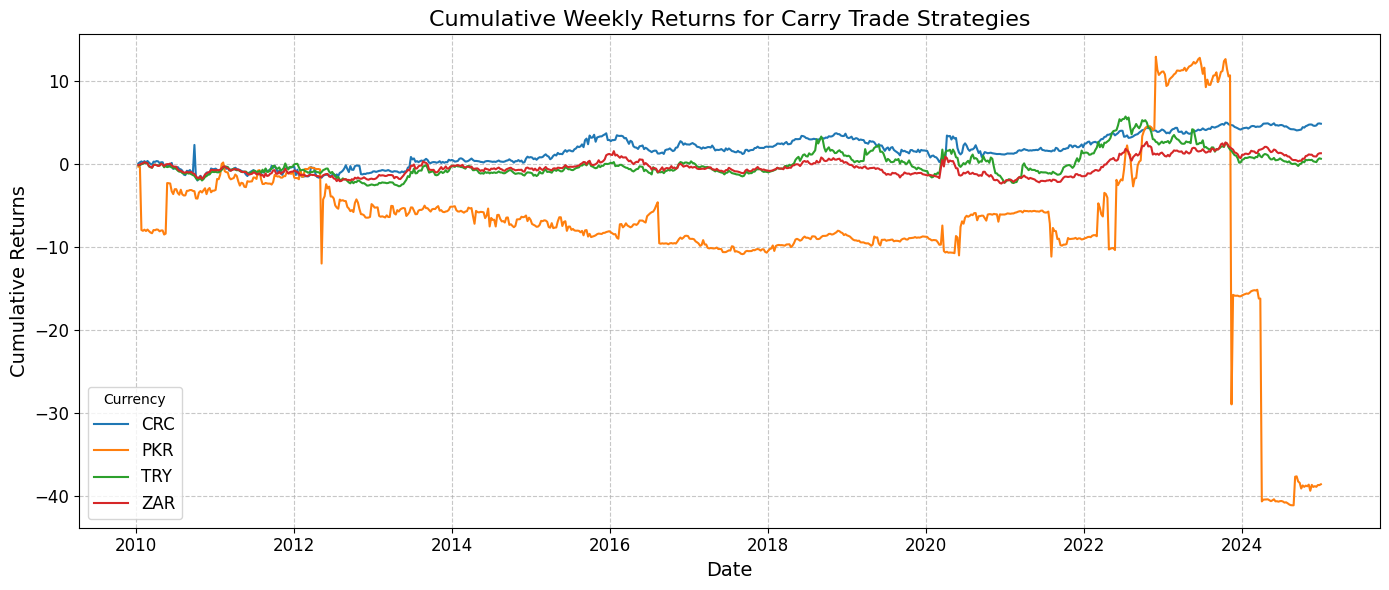

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(weekly_returns.cumsum())
plt.title('Cumulative Weekly Returns for Carry Trade Strategies', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.legend(weekly_returns.columns, title='Currency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

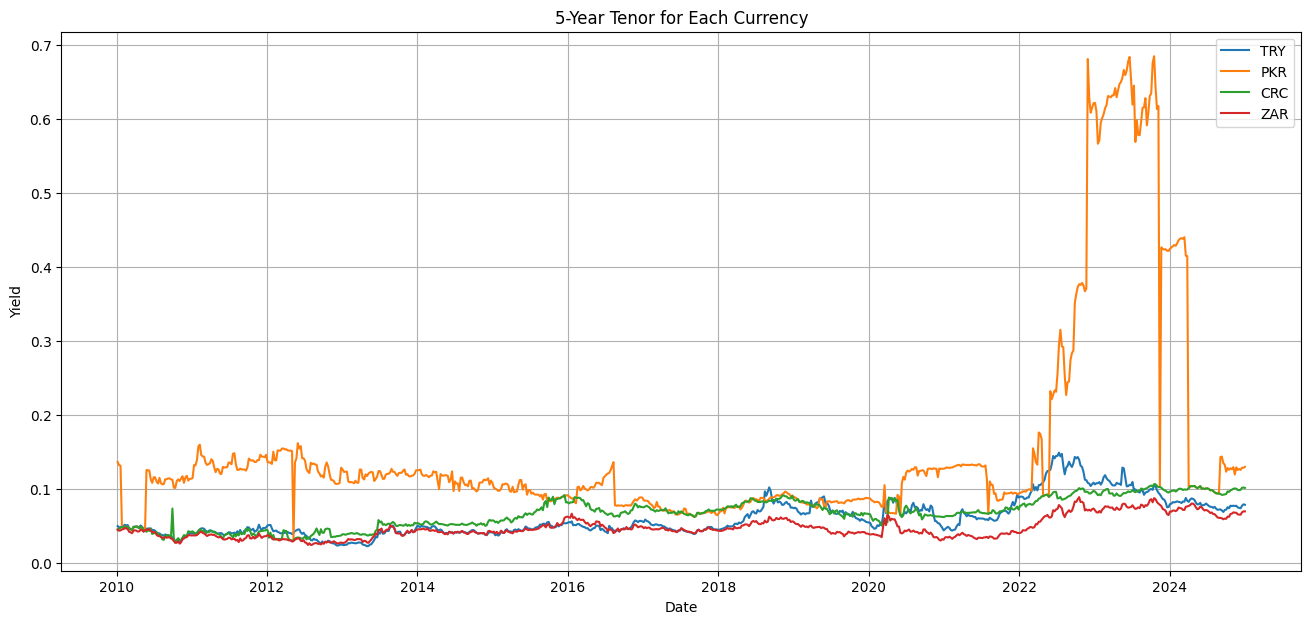

In [13]:
# Extract the 5-year tenor data for each currency
tenor_5y = swap_weekly.xs(5.0, level='tenor')

# Plot the 5-year tenor for each currency
plt.figure(figsize=(16, 7))
for currency in curr_list:
    plt.plot(tenor_5y.index, tenor_5y[currency], label=currency)

plt.title('5-Year Tenor for Each Currency')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

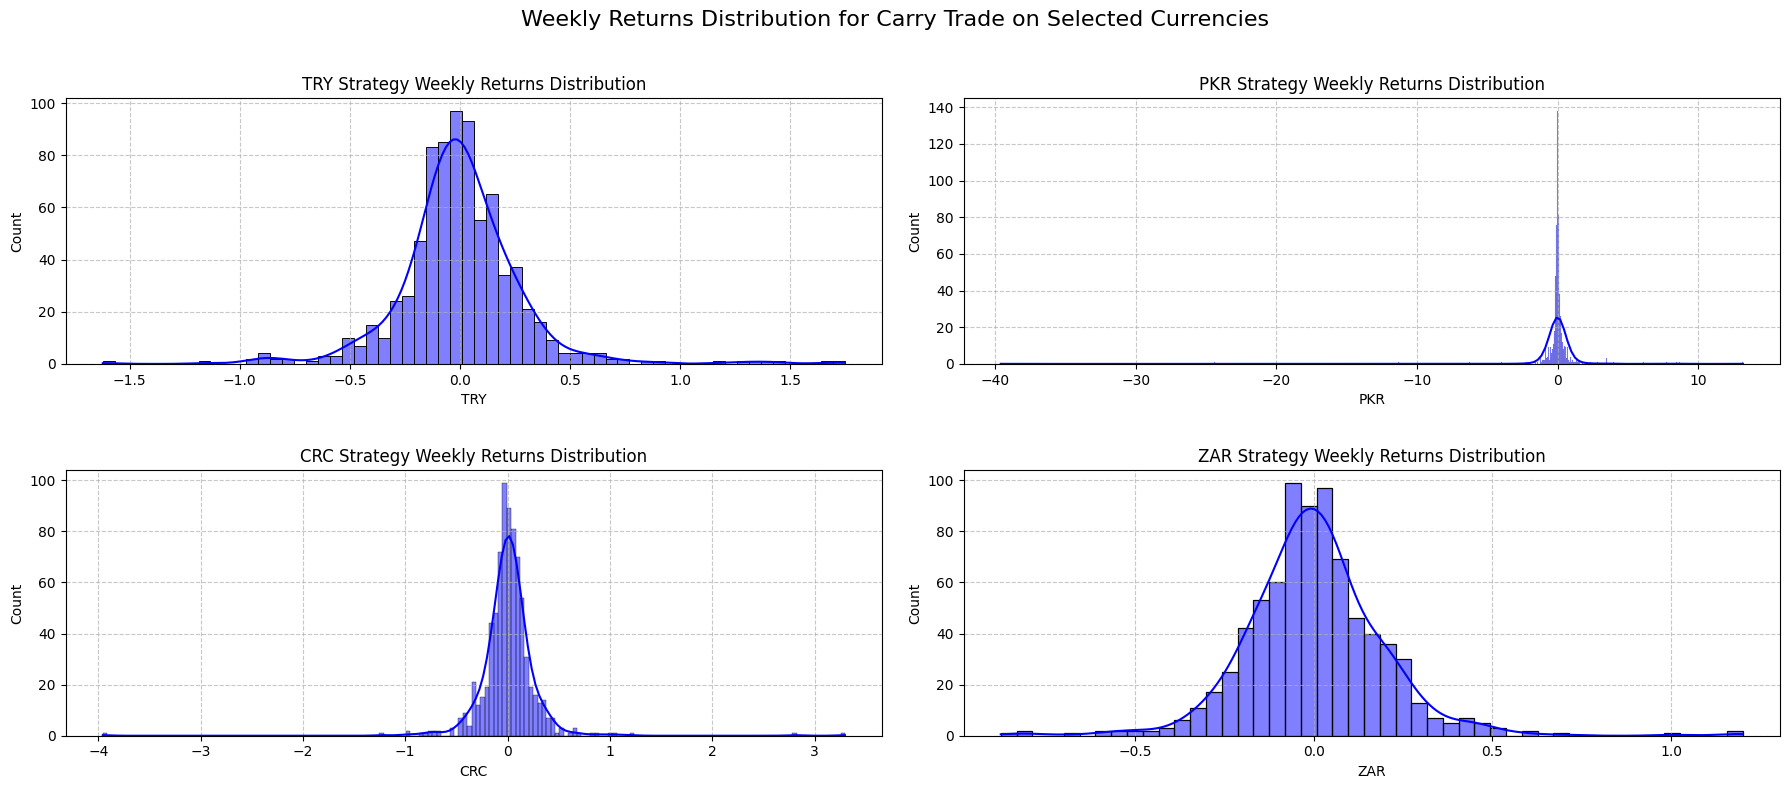

In [14]:
curr_list = ['TRY', 'PKR', 'CRC', 'ZAR']

fig, ax = plt.subplots(2, 2, figsize=(18, 8))

for i, carry_col in enumerate(curr_list):
    row = i // 2
    col = i % 2
    
    # Histogram with KDE
    sns.histplot(weekly_returns[carry_col], kde=True, ax=ax[row, col], color='blue')
    ax[row, col].set_title(f"{carry_col} Strategy Weekly Returns Distribution")
    ax[row, col].grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Weekly Returns Distribution for Carry Trade on Selected Currencies', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

In [15]:
calc_risk_metrics(weekly_returns)

,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,VaR per Vol,Max Drawdown,Peak,MDD Bottom,Recovery,MDD Peak,Duration (days)
currency,,,,,,,,,,,,,
CRC,-0.27237,62.38817,-0.33778,-0.62315,-3.95600,3.29683,-1.10649,-3.10996,2010-02-10,2011-02-09,-,2010-02-10,-
PKR,-12.21885,236.96938,-0.83807,-3.49472,-39.59693,13.17964,-0.42293,-21.10387,2010-01-13,2010-05-26,-,2010-01-13,-
TRY,0.67572,8.01292,-0.41538,-0.63563,-1.62157,1.74797,-1.46530,-1.00000,2010-02-10,2020-04-22,-,2010-02-10,-
ZAR,0.53354,5.40156,-0.27330,-0.41247,-0.87598,1.20094,-1.40307,-1.00000,2010-02-10,2024-09-18,-,2010-02-10,-


In [16]:
calculate_return_metrics(weekly_returns, adj=52)

,Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,VaR (0.05),Max Drawdown,Excess Kurtosis,Annualized Sortino Ratio
currency,,,,,,,,
CRC,0.32231,2.20133,0.14642,-0.27237,-0.33778,-3.10996,62.38817,0.17286
PKR,-2.56346,14.28952,-0.17939,-12.21885,-0.83807,-21.10387,236.96938,-0.14027
TRY,0.04200,2.04419,0.02055,0.67572,-0.41538,-1.00000,8.01292,0.02995
ZAR,0.08598,1.40464,0.06121,0.53354,-0.27330,-1.00000,5.40156,0.09534


### Correlations

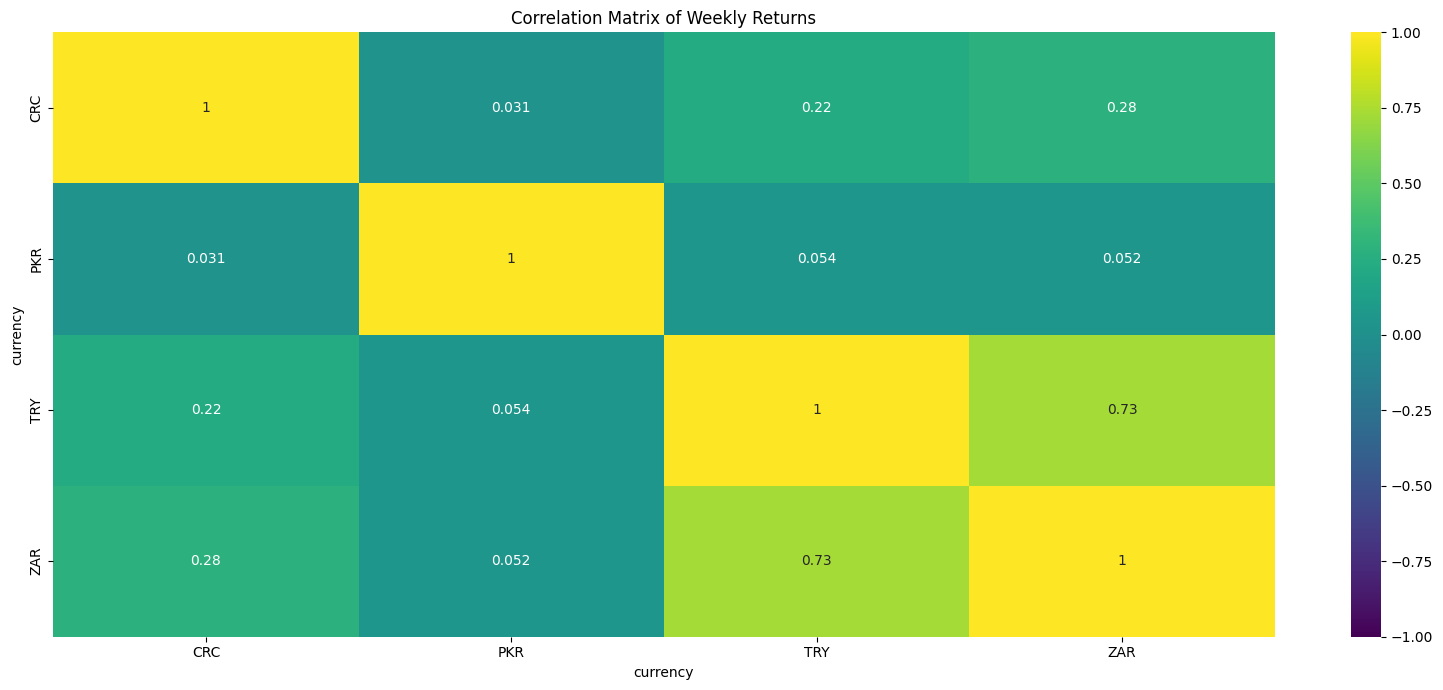

In [17]:
# Create a heatmap
plt.figure(figsize=(16, 7))
sns.heatmap(
    weekly_returns.corr(), 
    annot=True,
    cmap='viridis',  
    vmin=-1, 
    vmax=1, 
    center=0
)
plt.title('Correlation Matrix of Weekly Returns')
plt.tight_layout()

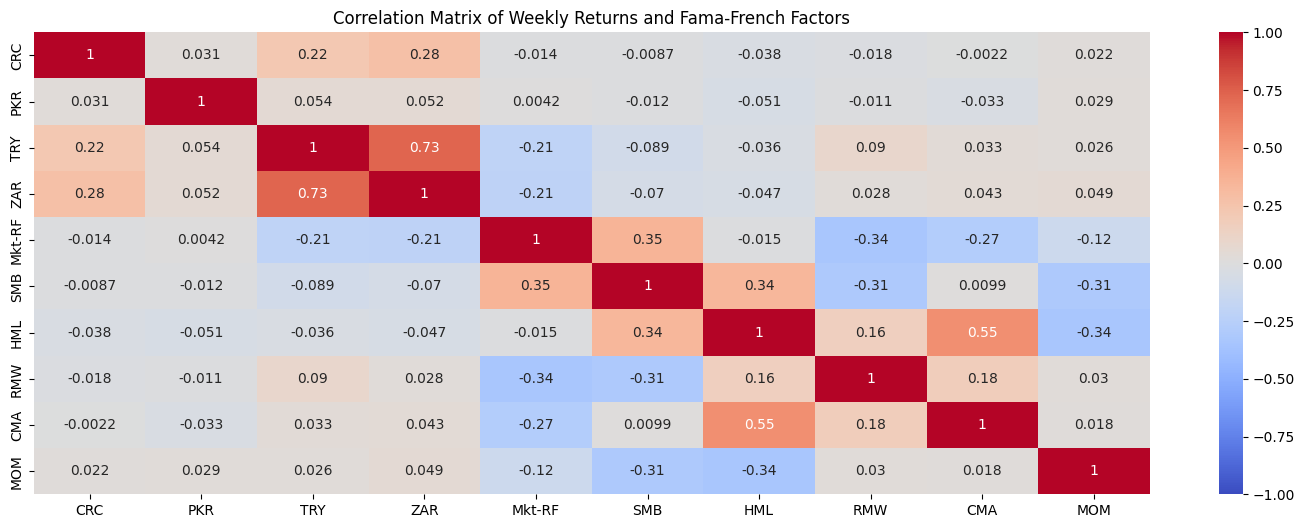

In [18]:
plt.figure(figsize=(18, 6))
sns.heatmap(weekly_returns_ff.drop(columns=['RF']).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Weekly Returns and Fama-French Factors')
plt.show()

### Factor Exposure

In [19]:
calculate_return_metrics(weekly_returns_ff.drop(columns=['RF']), adj=52)

,Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,VaR (0.05),Max Drawdown,Excess Kurtosis,Annualized Sortino Ratio
CRC,0.32231,2.20133,0.14642,-0.27237,-0.33778,-3.10996,62.38817,0.17286
PKR,-2.56346,14.28952,-0.17939,-12.21885,-0.83807,-21.10387,236.96938,-0.14027
TRY,0.04200,2.04419,0.02055,0.67572,-0.41538,-1.00000,8.01292,0.02995
ZAR,0.08598,1.40464,0.06121,0.53354,-0.27330,-1.00000,5.40156,0.09534
Mkt-RF,2.67913,7.91111,0.33865,-0.35721,-1.68000,-9.14042,3.80345,0.43310
SMB,-2.09396,4.78129,-0.43795,-0.07656,-1.04950,-1.00420,4.22873,-0.64795
HML,-0.17422,5.85429,-0.02976,-0.28550,-1.26950,-1.00042,6.07529,-0.03946
RMW,-0.21611,3.50603,-0.06164,0.20772,-0.76000,-1.00039,1.74950,-0.09589
CMA,0.01263,3.03523,0.00416,0.15442,-0.68900,-1.00000,4.10106,0.00583
MOM,0.44286,7.18410,0.06165,-0.04865,-1.71900,-1.00491,4.19916,0.08306


In [22]:
calc_performance_stats_regressions(
    df=weekly_returns_ff[['CRC', 'PKR', 'TRY', 'ZAR']],       # Dependent variables (excess returns of CRC, PKR, TRY, ZAR)
    market=weekly_returns_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']],          # Independent variables (Mkt-RF, SMB, HML)
    risk_free_rate=0,        # We already subtracted RF from the assets, so set 0 here
    adj=52,                  # Annualize with factor 52 (for weekly data)
    intercept=True,          # Include alpha
    save_residuals=False,    
    save_predicted=False
).T

,CRC,PKR,TRY,ZAR
Alpha,0.33844,-2.55339,0.18663,0.20159
Beta_Mkt-RF,-0.00480,0.00023,-0.05149,-0.04062
Beta_SMB,0.00479,0.02123,0.00187,0.00641
Beta_HML,-0.01844,-0.10318,-0.01810,-0.01440
Beta_RMW,-0.01101,-0.00613,0.01827,-0.01539
Beta_CMA,0.01670,-0.04345,0.00099,0.00907
Beta_MOM,0.00213,0.03390,-0.00452,0.00156
Sortino Ratio,0.17286,-0.14027,0.02995,0.09534
Treynor Ratio,-67.18555,-10930.99951,-0.81568,-2.11680
Information Ratio,0.15393,-0.17895,0.09343,0.14727


### Replication with ETFs

I select the following set of ETFs based on its date availability (available during the strategy period), and its relation to the carry trade strategy.

- IGLS: IShares UK Gilts 0-5yrs UCITS ETF -  Tracks UK government bonds in the short-term space.
- FXB: Invesco CurrencyShares British Pound Sterling Trust (FXB) – GBP strength or weakness affects your funding cost.
- UUP: Invesco DB US Dollar Index Bullish Fund (UUP) – Measures broad USD strength. 
- SHY: iShares 1-3 Year Treasury Bond ETF (SHY) – Represents short-term US rates, important for understanding relative rate differentials.
- TUR: iShares MSCI Turkey ETF (TUR) – Tracks Turkish equities; heavily influenced by TRY strength.
- EZA: iShares MSCI South Africa ETF (EZA) – Tracks South African equities; influenced by ZAR strength.
- AFK: VanEck Africa ETF (AFK) – Broader African market exposure, including ZAR.
- EMB: iShares Emerging Markets Bond ETF (EMB) – Tracks USD-denominated EM bonds.
- SPY: SPDR S&P 500 ETF (SPY) – General risk sentiment proxy.
- EEM: iShares MSCI Emerging Markets ETF (EEM) – Tracks overall EM equity performance.
- HYG: iShares iBoxx $ High Yield Corporate Bond ETF (HYG) – Risk appetite in the credit space.
- GLD: iShares Gold Trust (IAU) / SPDR Gold Shares (GLD) – Gold strengthens when carry trades unwind (safe-haven asset).
- TLT: iShares 20+ Year Treasury Bond ETF (TLT) – Long-duration U.S. Treasuries tend to rally during risk-off events.
- VXX: Path Series B S&P 500 VIX Short-Term Futures ETN


In [23]:
etf_list = ['SPY', 'IGLS', 'FXB', 'UUP', 'SHY', 'TUR', 'EZA', 'AFK', 'EMB', 'EEM', 'HYG', 'GLD', 'TLT', 'VXX'] 
etf_data_raw = nasdaqdatalink.get_table(
    'QUOTEMEDIA/PRICES',
    date={'gte': start_date, 'lte': end_date},
    ticker=etf_list,
    paginate = True
).sort_values(by='date')

# We'll pivot so that each ticker's returns can be calculated
etf_data = etf_data_raw.pivot(index='date', columns='ticker', values='adj_close').sort_index()

# Convert daily to weekly returns
etf_weekly = etf_data.resample('W-WED').last().pct_change().dropna()


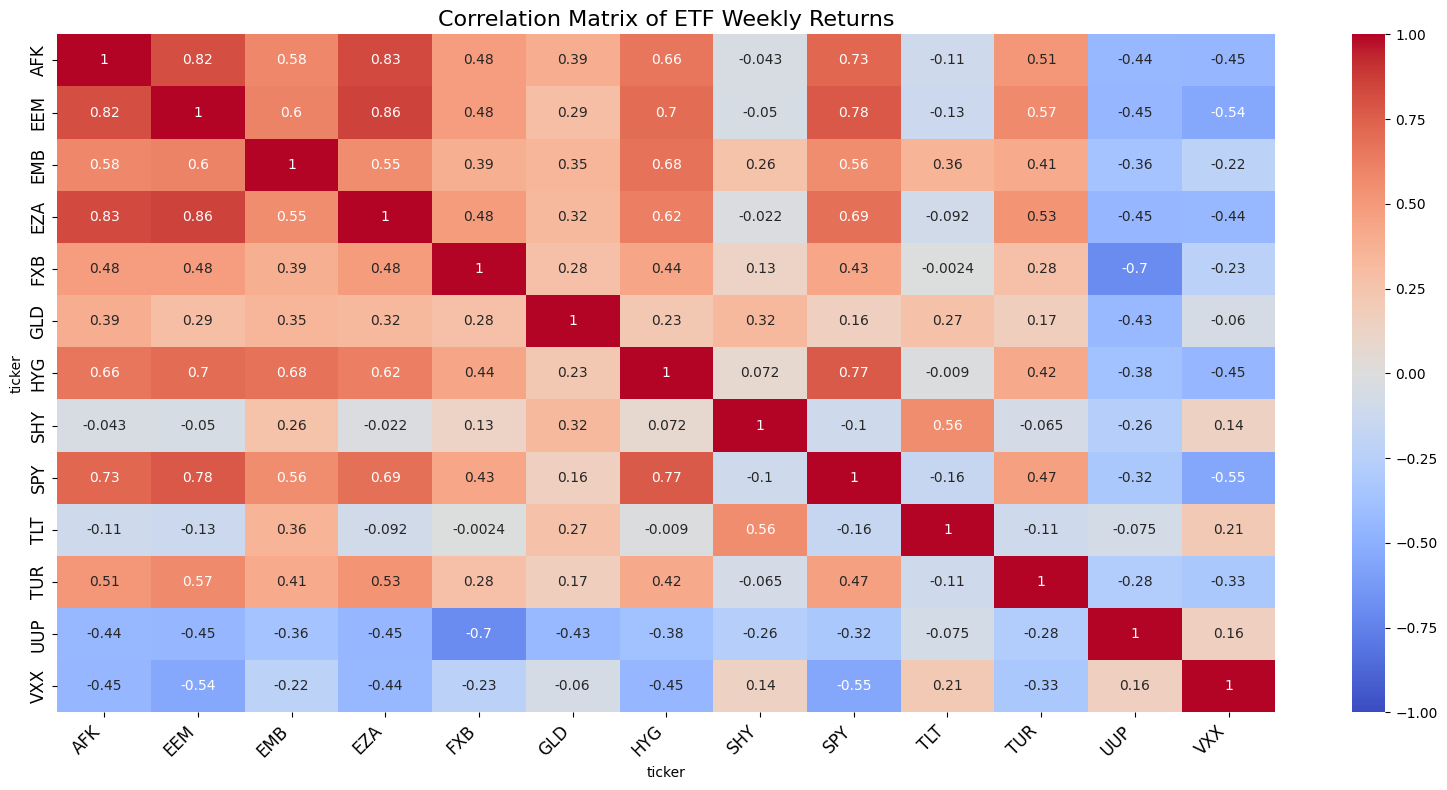

In [24]:
plt.figure(figsize=(16, 8))
sns.heatmap(etf_weekly.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of ETF Weekly Returns', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [25]:
# Replicate the returns using a set of ETFs
calc_performance_stats_regressions(
    df=weekly_returns_ff[['CRC', 'PKR', 'TRY', 'ZAR']],       # Dependent variables (excess returns of CRC, PKR, TRY, ZAR)
    market=etf_weekly,          # Independent variables (Mkt-RF, SMB, HML)
    risk_free_rate=0,        # We already subtracted RF from the assets, so set 0 here
    adj=52,                  # Annualize with factor 52 (for weekly data)
    intercept=True,          # Include alpha
    save_residuals=False,    
    save_predicted=False
).T

,CRC,PKR,TRY,ZAR
Alpha,0.82845,-3.75277,0.44582,0.60126
Beta_AFK,-0.66006,-14.67541,-0.34525,-0.02487
Beta_EEM,0.21361,1.43467,1.02035,0.71412
Beta_EMB,-1.59877,-5.07141,-10.72057,-7.28092
Beta_EZA,-0.20823,0.47225,-0.68609,-1.53192
Beta_FXB,0.13625,-2.23658,1.12671,1.14398
Beta_GLD,-0.45530,2.18165,0.38558,-0.03326
Beta_HYG,-3.22711,10.42274,2.14885,-1.62096
Beta_SHY,-33.99901,-54.73539,-12.99447,-18.93605
Beta_SPY,2.06900,6.13331,0.03338,0.90013


In [26]:
# Replicate the returns using a set of ETFs and save predicted values
predicted_values = {}

for currency in ['CRC', 'PKR', 'TRY', 'ZAR']:
    result = calc_performance_stats_regressions(
        df=weekly_returns_ff[[currency]],       # Dependent variable (excess returns of the currency)
        market=etf_weekly,                      # Independent variables (ETFs)
        risk_free_rate=0,                       # We already subtracted RF from the assets, so set 0 here
        adj=52,                                 # Annualize with factor 52 (for weekly data)
        intercept=True,                         # Include alpha
        save_residuals=False,    
        save_predicted=True                     # Save predicted values
    )
    predicted_values[currency] = result[currency]

# Convert the predicted values dictionary to a DataFrame
predicted_df = pd.DataFrame(predicted_values)

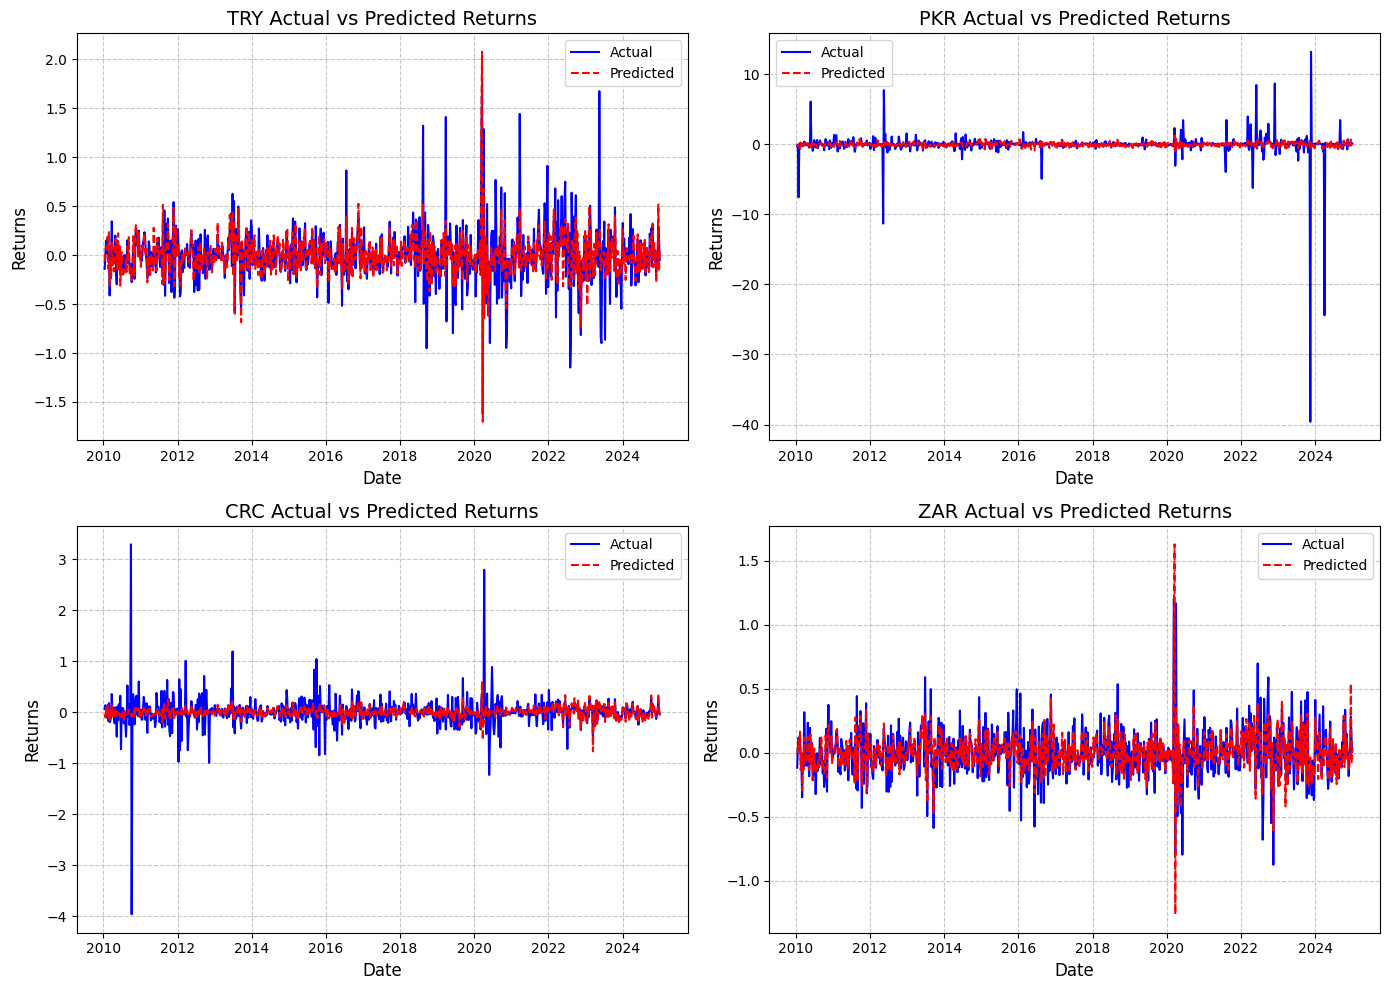

In [27]:
# Plot actual vs predicted values for each currency
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, currency in enumerate(curr_list):
    row = i // 2
    col = i % 2
    
    axes[row, col].plot(weekly_returns.index, weekly_returns[currency], label='Actual', color='blue', linewidth=1.5)
    axes[row, col].plot(predicted_df.index, predicted_df[currency], label='Predicted', color='red', linestyle='--', linewidth=1.5)
    axes[row, col].set_title(f'{currency} Actual vs Predicted Returns', fontsize=14)
    axes[row, col].set_xlabel('Date', fontsize=12)
    axes[row, col].set_ylabel('Returns', fontsize=12)
    axes[row, col].legend(fontsize=10)
    axes[row, col].grid(True, linestyle='--', alpha=0.7)
    axes[row, col].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

### Alternative representation of carry risk

### Representation as a put option

In [28]:
# Set up the thresholds for nonlinearity
k1 = 0.03  # Up-market threshold (call-like factor)
k2 = -0.03  # Down-market threshold (put-like factor)

# Define market excess return (SPY as market proxy)
market_excess = etf_weekly["SPY"]

# Compute the nonlinear terms
market_positive = np.maximum(market_excess - k1, 0)  # Captures excess exposure to up-markets (call-like)
market_negative = np.maximum(k2 - market_excess, 0)  # Captures excess exposure to down-markets (put-like)

# Construct the factor dataset for regression
factor_df = pd.DataFrame({
    "Market": market_excess,      # Normal market exposure
    "Up-Market": market_positive, # Call-like exposure
    "Down-Market": market_negative # Put-like exposure
}, index=etf_weekly.index)

# Running the nonlinear exposure regression using your function
regression_results = calc_performance_stats_regressions(
    df=weekly_returns_ff[['CRC', 'PKR', 'TRY', 'ZAR']],  # Carry trade excess returns
    market=factor_df,  # Independent variables: Market, Up-Market, Down-Market
    risk_free_rate=0,  # Already excess returns, so no risk-free adjustment needed
    adj=52,  # Annualization factor for weekly data
    intercept=True,  # Include alpha
    save_residuals=False,
    save_predicted=False
).T

regression_results


,CRC,PKR,TRY,ZAR
Alpha,0.11226,-2.47618,0.41857,0.53244
Beta_Market,-2.31113,-2.03220,-4.22213,-3.22806
Beta_Up-Market,16.71142,9.93550,0.23221,-2.13701
Beta_Down-Market,-1.00194,-2.40304,3.13013,1.25669
Sortino Ratio,0.17286,-0.14027,0.02995,0.09534
Treynor Ratio,-0.13946,1.26142,-0.00995,-0.02664
Information Ratio,0.05232,-0.17332,0.22099,0.41567
Tracking Error,2.14565,14.28640,1.89410,1.28090
R-Squared,0.04995,0.00044,0.14145,0.16842


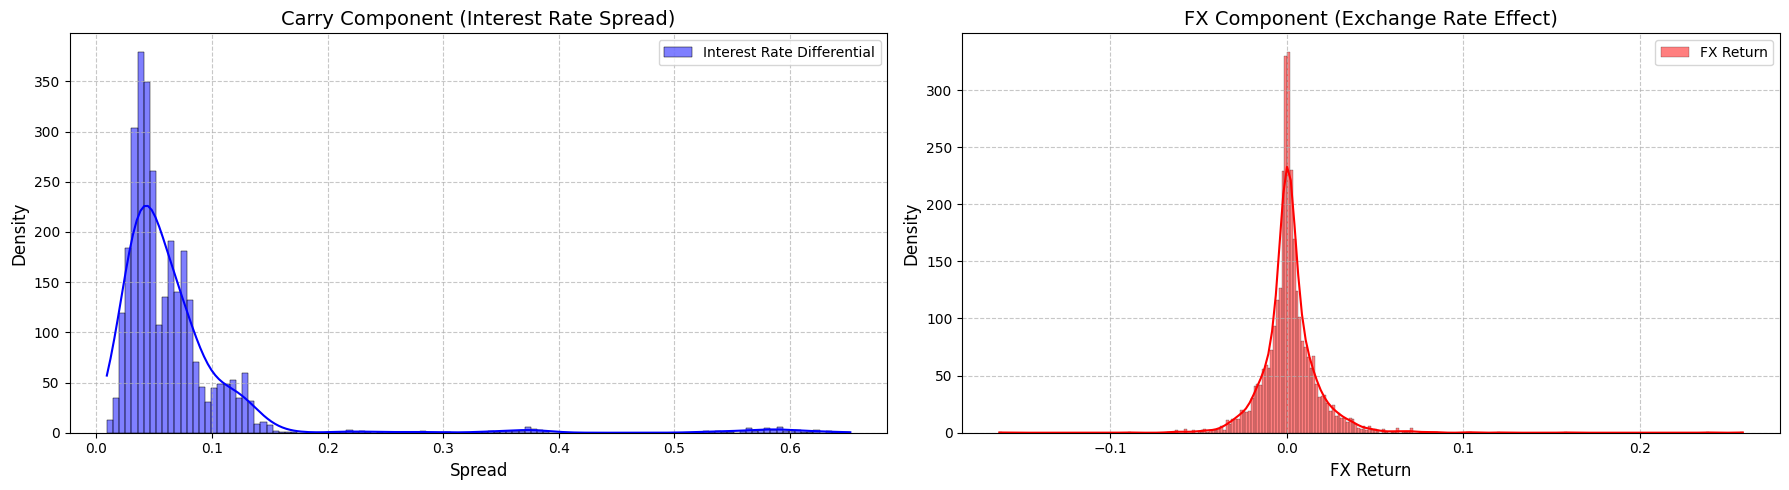

In [29]:
# Compute FX Component
final_df["fx_component"] = (final_df["fx_out"] / final_df["fx_in"]) - 1
final_df["carry_component"] = final_df["spread"]  # Carry component = interest rate differential

# Plotting Decomposition
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Plot Carry Component
sns.histplot(final_df["carry_component"], kde=True, ax=ax[0], color="blue", label="Interest Rate Differential")
ax[0].set_title("Carry Component (Interest Rate Spread)", fontsize=14)
ax[0].set_xlabel("Spread", fontsize=12)
ax[0].set_ylabel("Density", fontsize=12)
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

# Plot FX Component
sns.histplot(final_df["fx_component"], kde=True, ax=ax[1], color="red", label="FX Return")
ax[1].set_title("FX Component (Exchange Rate Effect)", fontsize=14)
ax[1].set_xlabel("FX Return", fontsize=12)
ax[1].set_ylabel("Density", fontsize=12)
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

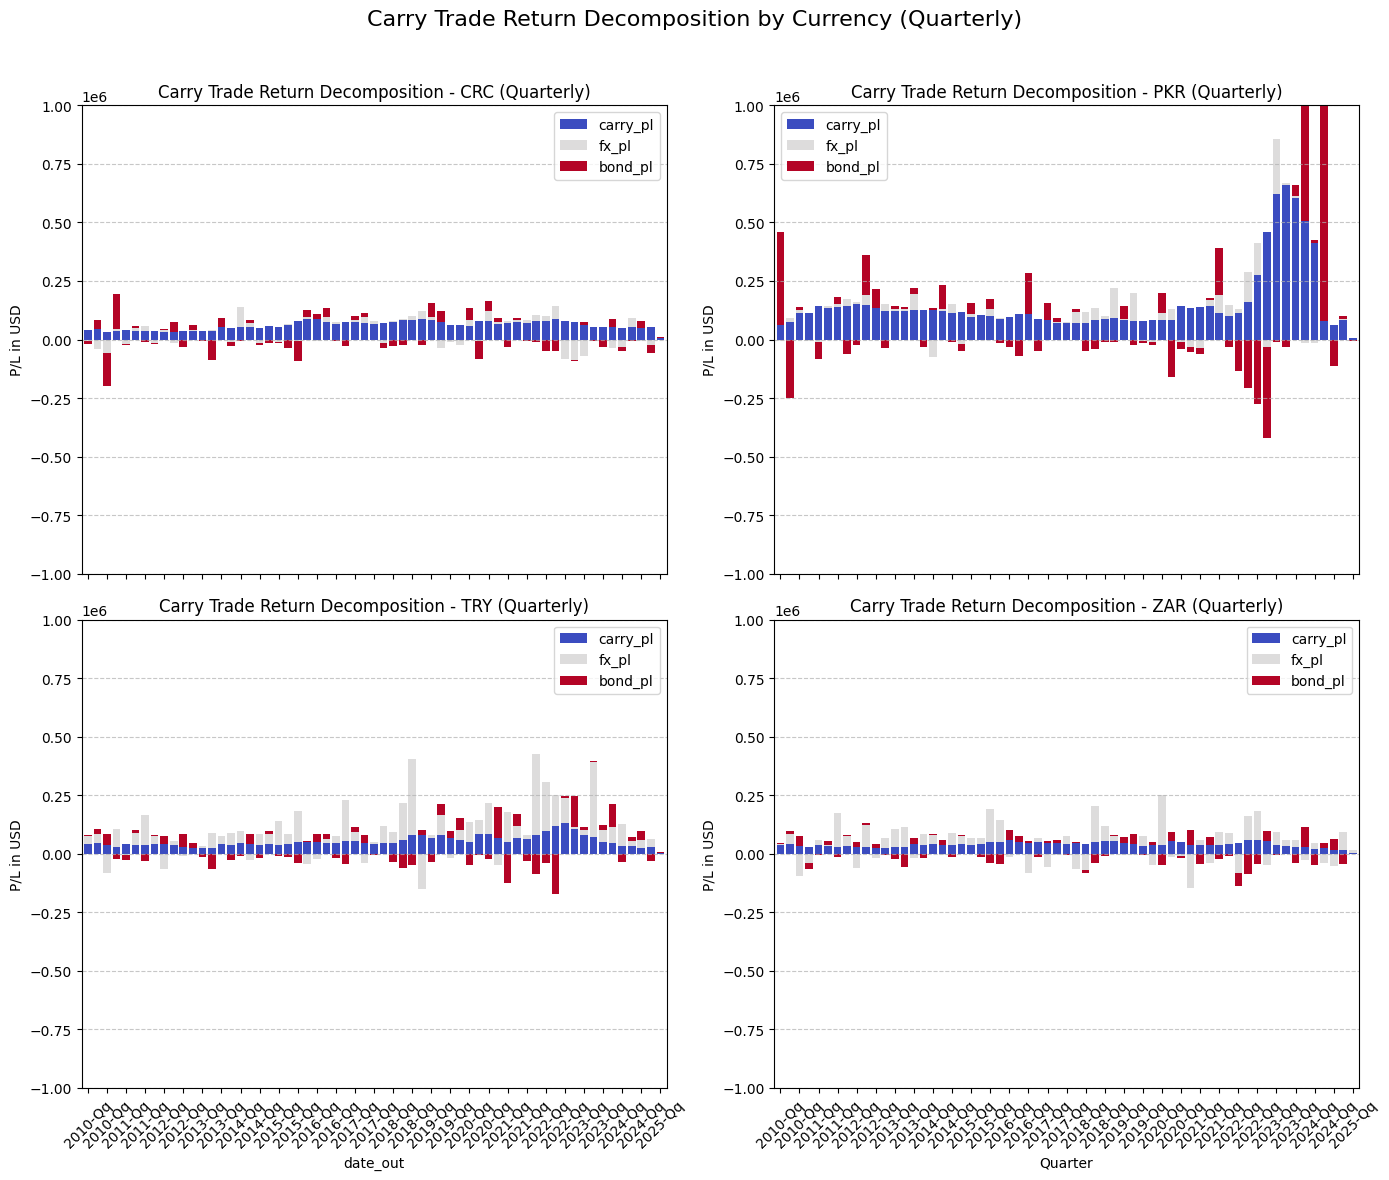

In [30]:
# Step 1: Compute Carry Return Component (Interest Rate Differential)
final_df["carry_return"] = (final_df["spread"] / 12)  # Monthly carry return
final_df["carry_pl"] = final_df["carry_return"] * 1e6  # Assuming $1M position

# Step 2: Compute FX Return Component
final_df["fx_return"] = (final_df["fx_out"] / final_df["fx_in"]) - 1
final_df["fx_pl"] = final_df["fx_return"] * 1e6  # FX impact in USD terms

# Step 3: Compute Residual Mark-to-Market Impact (Bond Price Changes)
final_df["bond_return"] = (final_df["new_price"] / final_df["entry_price"]) - 1
final_df["bond_pl"] = final_df["bond_return"] * 1e6  # Bond price movement effect

# Resampling to Quarterly Data for Better Visualization (Per Currency)
final_df.set_index("date_out", inplace=True)

# Get unique currencies
currencies = final_df["currency"].unique()

# Create a single figure with subplots for each currency
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True)

for i, currency in enumerate(currencies):
    # Filter data per currency and resample to quarterly frequency
    decomp_df = final_df[final_df["currency"] == currency][["carry_pl", "fx_pl", "bond_pl"]]
    decomp_df = decomp_df.resample('Q').sum()  # Aggregate quarterly

    ax = axes[i // 2, i % 2]
    decomp_df.plot(kind="bar", stacked=True, ax=ax, colormap="coolwarm", width=0.8)
    ax.set_title(f"Carry Trade Return Decomposition - {currency} (Quarterly)")
    ax.set_ylabel("P/L in USD")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Adjust x-axis formatting: Show only every 2nd quarter
    ticks = decomp_df.index.strftime('%Y-Q%q')  # Convert datetime to 'YYYY-Qq'
    ax.set_xticks(range(0, len(ticks), 2))  # Show every 2nd quarter
    ax.set_xticklabels(ticks[::2], rotation=45)  # Rotate for better readability
    ax.set_ylim(-1e6, 1e6)  # Adjust y-axis range for visibility

plt.suptitle("Carry Trade Return Decomposition by Currency (Quarterly)", fontsize=16)
plt.xlabel("Quarter")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Tangency Portfolio

In [32]:
weights, performance = find_tangency_weights(weekly_returns, reg_diag=1/2, adj_factor=52, expected_returns=None, add_stats=True, portfolio_performance=True)
weights

,Weights,Mean Annual Return,Annual Volatility,Sharpe Ratio
currency,,,,
CRC,0.86378,0.32231,2.20133,0.14642
PKR,-0.16993,-2.56346,14.28952,-0.17939
TRY,-0.33140,0.04200,2.04419,0.02055
ZAR,0.63755,0.08598,1.40464,0.06121


In [33]:
performance.T

,Tangency Portfolio
Annualized Return,0.75491
Annualized Volatility,3.15046
Sharpe Ratio,0.23962
Skewness,5.60720
VaR (0.05),-0.37219
Max Drawdown,-1.08098
Excess Kurtosis,90.50805
Annualized Sortino Ratio,0.37633


## Conclusion

The FX carry trade strategy implemented in this study exploit interest rate differentials between GBP (funding currency) and high-yielding emerging market currencies (CRC, PKR, TRY, ZAR). The results highlight both the significant tail risks associated with this approach.

- Return Distribution & Risk Metrics:
1. The strategy returns were highly skewed, particularly for PKR, indicating large negative outliers.
2. High excess kurtosis suggests fat-tailed distributions, meaning the strategy occasionally suffered extreme losses.
3. VaR and CVaR metrics confirmed substantial downside risk, particularly in volatile periods.

- Factor Exposure:
1. Regression results against common risk factors (Fama-French and ETFs) showed low systematic market exposure, indicating that carry trade returns were not easily replicable using traditional asset classes.
2. The ETF-based replication showed weak correlations with broad equity indices but some sensitivity to emerging market debt (EMB), FXB (GBP strength), and volatility instruments (VXX).

- Put-Like Behavior and Systematic Risk:
1. The nonlinear regression analysis confirmed that the strategy behaves like a short put option—it earns steady returns in calm markets but collapses during risk-off environments when high-yield currencies depreciate sharply.
2. The significant negative beta to down-markets (β_d) suggests that the strategy is highly vulnerable to currency crises and flight-to-safety episodes.

- Carry vs. FX Risk Decomposition:
1. The decomposition of returns showed that interest rate differentials (carry component) provide a consistent return stream, while FX fluctuations introduce significant volatility.
2. The FX component often eroded carry returns, reinforcing the notion that currency depreciation is the primary driver of losses.

- Portfolio Optimization:
- A tangency portfolio approach suggested that allocating weights across different carry trades could slightly improve the Sharpe ratio, though risks remained elevated.